## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [1]:
# Put your imports here
import random
import itertools
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# import randforest classifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

sns.set()
pd.options.display.max_columns = None

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
data_folder = './austin-animal-center-shelter-intakes-and-outcomes'

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

We first define a function called "Regression" which help us to apply use regression model with using the original features (X) or an augmented version of it (if poly_ = true). More so you could use it to add a regularization term (lasso/ridge).   

In [3]:
def Regression (X,y, poly_, type_ ,alpha_):
# Function that takes in input:
# 1) data points (inputs - outputs) --> X, y
# 2) poly_ = True/False, if an augmented input vector is wanted
# 3) type_ = 'linearRegression'/'ridge'/'lasso'
# 4) alpha_ = regularization factor
    x = np.linspace(0, X.max(), len(y))
    if(poly_):
        poly = PolynomialFeatures(2)
        X = poly.fit_transform(X)
    if (type_ == 'linearRegression'):
        model = LinearRegression()
        model.fit(X, y)  # train it
        a = model.coef_;
        b = model.intercept_;
        y_pred = np.dot(a.T,X.T)+b#np.dot(a.T,X.T)+b;
    else:
        if(type_ == 'ridge'):
            model = Ridge(alpha=alpha_)
        else:
            if(type_ == 'lasso'):
                model = linear_model.Lasso()
            else:
                raise ValueError('type_ inputs is not known. Possible options are : linearRegression/ridge/lasso')
                # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
    prediction = cross_val_predict(model, X, y, cv=5)
    Rsq = r2_score(y, y_pred) 
    return y_pred, a, b, Rsq

As you will also see later, we will need another support function in order to compute the p-value of the regression model.

In [4]:
def CheckPValue (data_):
    ### STATSMODELS ###
    import statsmodels.formula.api as smf
    lm1 = smf.ols(formula='IncomePerCap ~ SelfEmployed', data=data_).fit()
    return lm1.pvalues

In [5]:
# Import and visualize the dataset
data_path = 'acs2015_county_data.csv'
data = pd.read_csv(data_path, index_col=0)
data.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


Let's check the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties.

In [6]:
# Clean the data: check for NaN and Inf 
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["SelfEmployed", "IncomePerCap"], how="all")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/home/ahmed/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ahmed/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


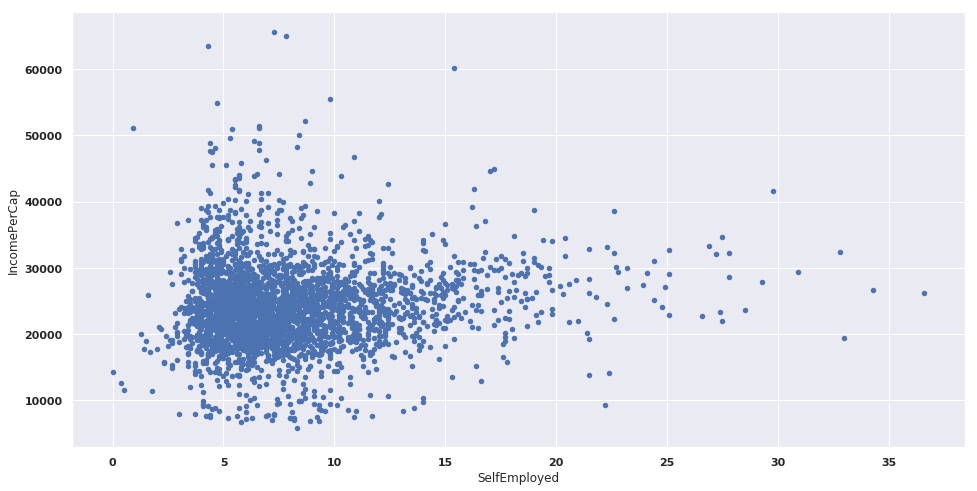

In [7]:
# Let's take a general look at the two variable 
plt2 = data.plot.scatter('SelfEmployed','IncomePerCap', figsize=(16, 8), grid=True)

From scatter plot one can see that there is not a clear linear relationship between self employed and income per capita. This can be also confirmed by the Paerson coefficient, as follows:

In [8]:
# Correlation coefficient
data.corr()['SelfEmployed']['IncomePerCap'] 

0.08727386609551845

As expected the correlation coefficient is quite small.

We can also evaluate how well a linear function can explain our data by applying regression and check the coefficient of determination which is defined as the proportion of the variance in the dependent variable that is predictable from the independent variable. 

/home/ahmed/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


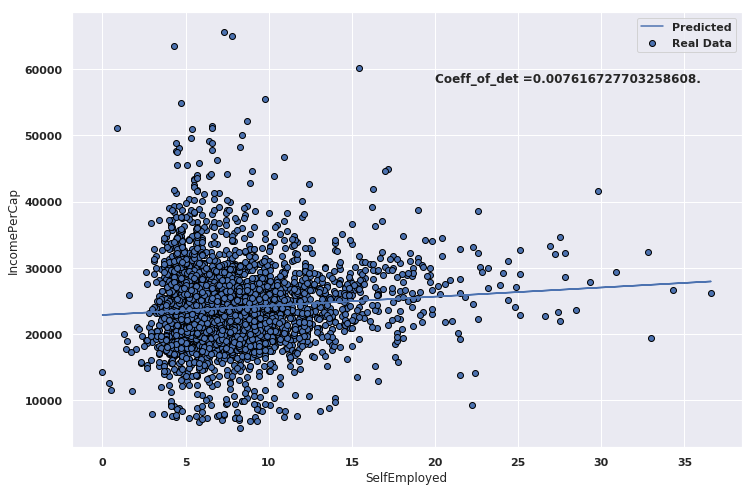

In [9]:
# Let's use a linear regression model


matplotlib.rcParams.update({'font.size': 12})
X = data['SelfEmployed']
X = X.values.reshape(-1, 1)
y=data['IncomePerCap']
prediction, a, b, Rsq= Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.scatter(X, y, edgecolors=(0, 0, 0))
#ax.scatter(X, prediction, edgecolors=(0, 0, 0))
ax.plot(X, prediction)
ax.set_xlabel('SelfEmployed')
ax.set_ylabel('IncomePerCap')
ax.legend(['Predicted', 'Real Data'])
stringa = 'Coeff_of_det =%(number)s.' %{"number": str(Rsq)}
plt.text(20, 58000, stringa)
plt.show()

Also in this case the best fit has a coefficient of determination of 0.007, which is quite small since it ranges between 0 and 1.

Let's check the p-value for the data:

In [10]:
CheckPValue(data)

Intercept       0.000000e+00
SelfEmployed    7.052861e-07
dtype: float64

The P value, that in our case is less than 0.05, indicates that one can reject the null hypothesis that the coefficient equals zero (no effect). Given the previous results (coefficient of detetermination small) one can argue how this is even possible. The coefficient of determination numerically describe the variability of the data around the regression line. The low R-squared shows that even noisy, high-variability data can have a significant trend. The trend indicates that the predictor variable still provides information about the response even though data points fall further from the regression line.

So coming to the question "do citizens in counties that have a higher percentage of self-employed people earn more per capita", we cannot say that this is not true.

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

In [11]:
# Filter the dataset with respect to the States under analysis
data_reduced = data[(data['State'] == 'Wisconsin') | (data['State'] =='Tennessee') | (data['State'] =='Minnesota')]

/home/ahmed/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


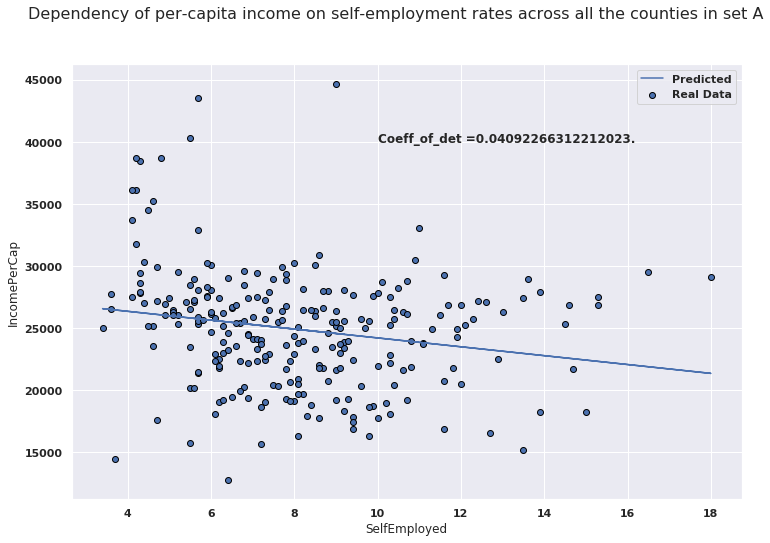

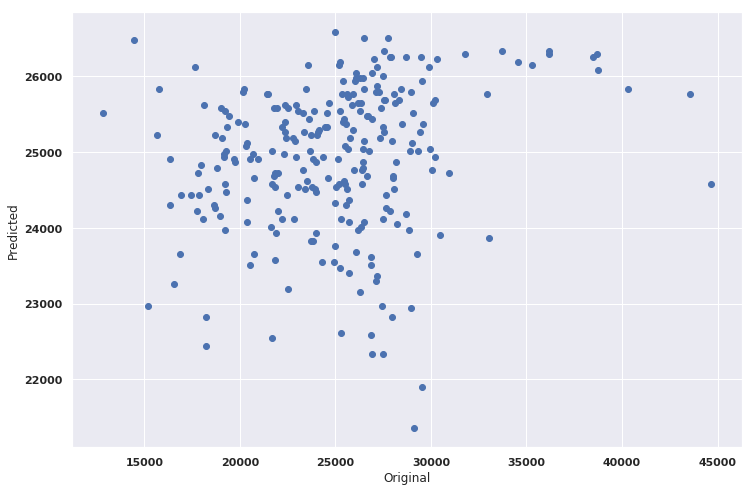

In [12]:
# We use the "Regression" function defined above in order to compute the linear regression function that better fit the data
# The function gives as output also the coefficient of determination 
matplotlib.rcParams.update({'font.size': 12})
X=data_reduced['SelfEmployed']
X = X.values.reshape(-1, 1)
y=data_reduced['IncomePerCap'].values
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))


# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y, edgecolors=(0, 0, 0))
ax.plot(X, prediction)
ax.set_xlabel('SelfEmployed')
ax.set_ylabel('IncomePerCap')
ax.legend(['Predicted', 'Real Data'])
stringa = 'Coeff_of_det =%(number)s.' %{"number": str(Rsq)}
plt.text(10, 40000, stringa)
fig.suptitle('Dependency of per-capita income on self-employment rates across all the counties in set A', fontsize=16)
plt.show()
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, prediction)#, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [13]:
CheckPValue (data_reduced)

Intercept       3.132976e-85
SelfEmployed    1.188164e-03
dtype: float64

Also in this case the p-value is significant (< 0.05) showing that we cannot say that there is no relationship between the explanatory and the response variable.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

In [14]:
#Let's select only the states we are intersted in
data_reduced_Win = data_reduced[(data_reduced['State'] == 'Wisconsin')]
data_reduced_Tenn = data_reduced[(data_reduced['State'] =='Tennessee')]
data_reduced_Minn= data_reduced[(data_reduced['State'] =='Minnesota')]

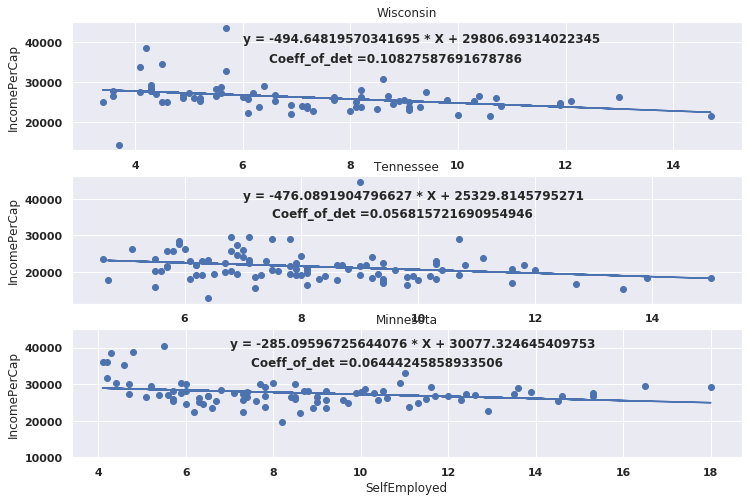

In [15]:
# Let's compute and plot the regression models for each State:

#Winsconsin
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
X = data_reduced_Win['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_Win['IncomePerCap'] 
ax[0].scatter(X,y)
ax[0].set_title('Wisconsin')
ax[0].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[0].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[0].text(6.5, 35000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[0].text(6, 40000, stringa2)

#Tennessee
X = data_reduced_Tenn['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_Tenn['IncomePerCap'] 
ax[1].scatter(X,y)
ax[1].set_title('Tennessee')
ax[1].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[1].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[1].text(7.5, 35000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[1].text(7, 40000, stringa2)


#Minnesota
X = data_reduced_Minn['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_Minn['IncomePerCap'] 
ax[2].scatter(X,y)
ax[2].set_title('Minnesota')
ax[2].set_xlabel('SelfEmployed')
ax[2].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[2].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[2].text(7.5, 35000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[2].text(7, 40000, stringa2)

ylim((10000, 45000)) 
plt.show()

In order to check in which state within set A is the observed effect of self-employment on per-capita income the strongest, one can look at the regression coefficient of each plot: the line which approximate the relationship between self-employment and per-capita income is more inclined (bigger coefficient) in the case of the Wisconsin state, showing that for smaller variation of the Self Employed percentage there is a bigger effect on the per-capita income.

In order to check the significance of the relationship between self emplyed and income per capita for each state, let's compute the p-values:

In [16]:
# Wisconsin
CheckPValue (data_reduced_Win)

Intercept       2.098209e-34
SelfEmployed    4.768135e-03
dtype: float64

In [17]:
# Tennessee
CheckPValue(data_reduced_Tenn)

Intercept       1.944572e-26
SelfEmployed    2.001163e-02
dtype: float64

In [18]:
# Minnesota
CheckPValue(data_reduced_Minn)

Intercept       2.388708e-44
SelfEmployed    1.766520e-02
dtype: float64

As you can see in all the cases we found that the relationship is statistically significant.

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

In [19]:
# Filter the dataset with respect to the States under analysis
data_reduced = data[(data['State'] == 'New Jersey') | (data['State'] =='Kansas') | (data['State'] =='Rhode Island')]

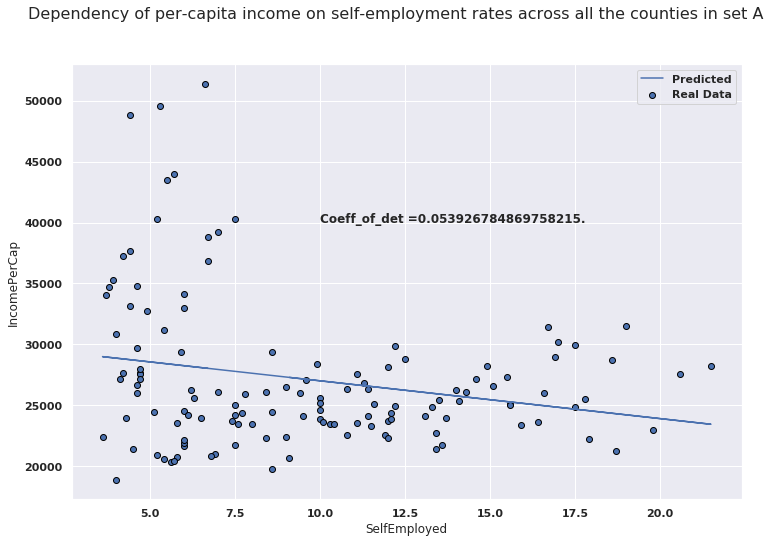

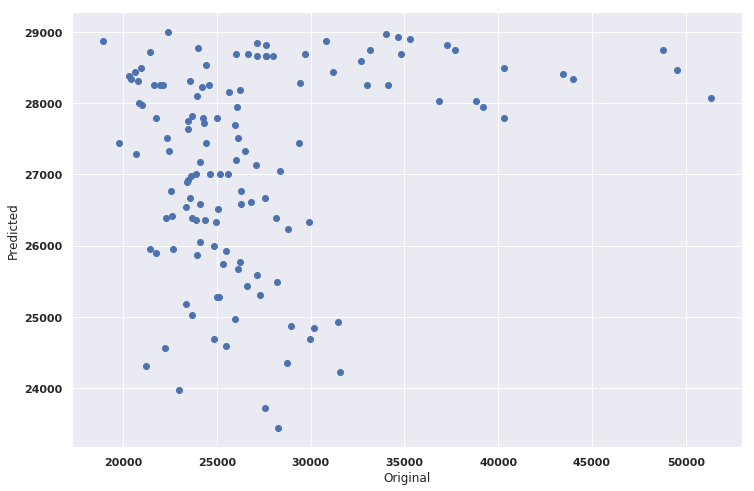

In [20]:
# We use the "Regression" function defined above in order to compute the linear regression function that better fit the data
# The function gives as output also the coefficient of determination 
matplotlib.rcParams.update({'font.size': 12})
X=data_reduced['SelfEmployed']
X = X.values.reshape(-1, 1)
y=data_reduced['IncomePerCap'].values
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))


# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y, edgecolors=(0, 0, 0))
ax.plot(X, prediction)
ax.set_xlabel('SelfEmployed')
ax.set_ylabel('IncomePerCap')
ax.legend(['Predicted', 'Real Data'])
stringa = 'Coeff_of_det =%(number)s.' %{"number": str(Rsq)}
plt.text(10, 40000, stringa)
fig.suptitle('Dependency of per-capita income on self-employment rates across all the counties in set A', fontsize=16)
plt.show()
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, prediction)#, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

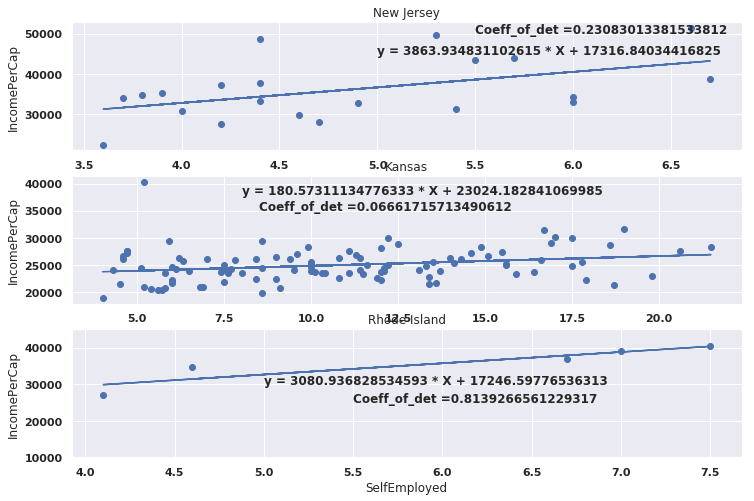

In [21]:
#Let's select only the states we are intersted in
data_reduced_NJ = data_reduced[(data_reduced['State'] == 'New Jersey')]
data_reduced_Kan = data_reduced[(data_reduced['State'] =='Kansas')]
data_reduced_RI= data_reduced[(data_reduced['State'] =='Rhode Island')]


# Compute and plot the regression models

#New Jersey
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
X = data_reduced_NJ['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_NJ['IncomePerCap'] 
ax[0].scatter(X,y)
ax[0].set_title('New Jersey')
ax[0].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[0].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[0].text(5.5, 50000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[0].text(5, 45000, stringa2)


#Kansas
X = data_reduced_Kan['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_Kan['IncomePerCap'] 
ax[1].scatter(X,y)
ax[1].set_title('Kansas')
ax[1].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[1].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[1].text(8.5, 35000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[1].text(8, 38000, stringa2)


#Rhode Island
X = data_reduced_RI['SelfEmployed']
X = X.values.reshape(-1, 1)
y = data_reduced_RI['IncomePerCap'] 
ax[2].scatter(X,y)
ax[2].set_title('Rhode Island')
ax[2].set_xlabel('SelfEmployed')
ax[2].set_ylabel('IncomePerCap')
prediction, a, b, Rsq = Regression (X,y, False, 'linearRegression' ,100)
x = np.linspace(0, X.max(), len(y))
ax[2].plot(X, prediction)
stringa1 = 'Coeff_of_det =%(number)s' %{"number": str(Rsq)}
ax[2].text(5.5, 25000, stringa1)
stringa2 = 'y = %(A)s * X + %(B)s' %{"A": str(a[0]), "B":str(b)}
ax[2].text(5, 30000, stringa2)

ylim((10000, 45000)) 
plt.show()

In [22]:
# NewJersey
CheckPValue(data_reduced_NJ)

Intercept       0.043371
SelfEmployed    0.027489
dtype: float64

In [23]:
# Kansas
CheckPValue(data_reduced_Kan)

Intercept       1.172762e-52
SelfEmployed    7.853352e-03
dtype: float64

In [24]:
# Rhode Island
CheckPValue(data_reduced_RI)

Intercept       0.045526
SelfEmployed    0.036183
dtype: float64

Also for these states the relationship between self employement and income per capita is significant, since the p-value is less than 0.05.

In order to incentivize the self-employment I would recommend the set B since, as you can see from the last plots, in all the interested States (New Jersey, Kansas and Rhode Island) the regression model representing the relationship between self employed and per-capita has positive coefficient, meaning that for an increment of the percentage of self employed there is an increment of the per-capita income. In the case of set A the regression line has a negative coefficient showing that for increment of self employement percentage there is a decrement of the per-capita income.

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

In [25]:
animal_df = pd.read_csv("aac_intakes_outcomes.csv")

In [26]:
# select only relevant columns
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake',
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)',
          'outcome_type']
animal_df = animal_df[columns]

In [27]:
# find the unique years
animal_df.intake_year.unique()

array([2017, 2014, 2013, 2015, 2016, 2018])

Since there are only 6 unique years we will convert them into one hot vectors

In [28]:
# find the unique number of  intake_number 
animal_df.intake_number.nunique()

13

In [29]:
# look at data types of features object data type gives us a hint that the feature might be categorical
animal_df.dtypes

animal_type                  object
intake_year                   int64
intake_condition             object
intake_number               float64
intake_type                  object
sex_upon_intake              object
age_upon_intake_(years)     float64
time_in_shelter_days        float64
sex_upon_outcome             object
age_upon_outcome_(years)    float64
outcome_type                 object
dtype: object

In [30]:
# look at mean and standard deviation before normalizing
animal_df.describe()

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years)
count,79672.000000,79672.000000,79672.000000,79672.000000,79672.000000
mean,2015.436101,1.126820,2.107785,16.757116,2.142592
std,1.303157,0.456057,2.893175,41.679359,2.900078
min,2013.000000,1.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,0.164384,1.102083,0.246575
50%,2015.000000,1.000000,1.000000,4.987153,1.000000
75%,2017.000000,1.000000,3.000000,13.610764,3.000000
max,2018.000000,13.000000,25.000000,1606.194444,25.000000


We convert the all categorical variables into one hot vectors except the variable outcome_type because we will use it for assigning the labels and after getting the labels we will drop this column.
We use all the dataset for the features dummy embedding. the assumption we make is that the user knows the dataset and all possible options for each feature. We assume that the training set contains all options for all features the same as for the testing set. This is almost always true since all respected data scientists preprocess the data before splitting and training models.

In [31]:
# convert the categorical variables into one hot vectors
animal_df_one_hot = pd.get_dummies(animal_df,columns=['intake_year','animal_type','intake_condition','intake_type',
                                               'sex_upon_intake', 'sex_upon_outcome'])
animal_df_one_hot.shape

(79672, 38)

Assign labels such that if animal is adopted then it gets label 1 else label is zero. Label of 1 denotes the positive class hereafter.

In [32]:
# assign labels to data
animal_df_one_hot['labels'] = [1 if x=='Adoption' else 0 for x in animal_df_one_hot.outcome_type]
animal_df_one_hot.drop('outcome_type',axis=1, inplace=True)

In [33]:
animal_df_one_hot.head()

,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),intake_year_2013,intake_year_2014,intake_year_2015,intake_year_2016,intake_year_2017,intake_year_2018,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,labels
0,1.0,10.0,0.588194,10.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,2.0,7.0,1.259722,7.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,3.0,6.0,1.113889,6.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,1.0,10.0,4.970139,10.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1.0,16.0,0.119444,16.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


We normalize the non-categorical variables by subtracting the mean of the features from each values and dividing each value by the standard deviation of the feature. Thus we have mean of the feature equal to zero and variance equal to one.
For this we use the mean and std of the training set.

In [34]:
# function to normalize non-categorical variables
def normalize(df,train_df):
    df['age_upon_intake_(years)'] = (df['age_upon_intake_(years)'] - train_df['age_upon_intake_(years)'].mean())/train_df['age_upon_intake_(years)'].std()
    df['time_in_shelter_days'] = (df['time_in_shelter_days'] - train_df['time_in_shelter_days'].mean())/train_df['time_in_shelter_days'].std()
    df['age_upon_outcome_(years)'] = (df['age_upon_outcome_(years)'] - train_df['age_upon_outcome_(years)'].mean())/train_df['age_upon_outcome_(years)'].std()
    return df

In [35]:
# split the data into train and test
# reset the indices 
train_df = animal_df_one_hot.sample(frac=0.8, random_state=7).reset_index(drop=True)
test_df = animal_df_one_hot.drop(train_df.index).reset_index(drop=True)            

In [36]:
# normalize the dataframe
#
test_df = normalize(test_df,train_df)
train_df = normalize(train_df,train_df)
train_df.describe()

,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),intake_year_2013,intake_year_2014,intake_year_2015,intake_year_2016,intake_year_2017,intake_year_2018,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,labels
count,63738.000000,6.373800e+04,6.373800e+04,6.373800e+04,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000,63738.000000
mean,1.128071,6.304119e-17,-5.049984e-17,2.106947e-17,0.052073,0.234303,0.235370,0.220700,0.219241,0.038313,0.004456,0.370470,0.569613,0.055461,0.004095,0.000973,0.050111,0.879915,0.023534,0.001851,0.000643,0.038878,0.003263,0.188475,0.063400,0.701418,0.043443,0.298315,0.317126,0.158430,0.141156,0.084957,0.116712,0.122360,0.353196,0.322759,0.084957,0.421099
std,0.461954,1.000000e+00,1.000000e+00,1.000000e+00,0.222175,0.423566,0.424233,0.414722,0.413736,0.191953,0.066603,0.482934,0.495134,0.228880,0.063861,0.031174,0.218177,0.325064,0.151593,0.042988,0.025355,0.193305,0.057033,0.391094,0.243683,0.457640,0.203855,0.457522,0.465361,0.365146,0.348185,0.278820,0.321080,0.327704,0.477967,0.467535,0.278820,0.493739
min,1.000000,-7.292487e-01,-4.075921e-01,-7.394250e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-6.726177e-01,-3.806470e-01,-6.546920e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,-3.847438e-01,-2.860684e-01,-3.957855e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.042659e-01,-7.423133e-02,2.914935e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,13.000000,7.883373e+00,3.398552e+01,7.851563e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
animal_df_one_hot.dtypes

intake_number                     float64
age_upon_intake_(years)           float64
time_in_shelter_days              float64
age_upon_outcome_(years)          float64
intake_year_2013                    uint8
intake_year_2014                    uint8
intake_year_2015                    uint8
intake_year_2016                    uint8
intake_year_2017                    uint8
intake_year_2018                    uint8
animal_type_Bird                    uint8
animal_type_Cat                     uint8
animal_type_Dog                     uint8
animal_type_Other                   uint8
intake_condition_Aged               uint8
intake_condition_Feral              uint8
intake_condition_Injured            uint8
intake_condition_Normal             uint8
intake_condition_Nursing            uint8
intake_condition_Other              uint8
intake_condition_Pregnant           uint8
intake_condition_Sick               uint8
intake_type_Euthanasia Request      uint8
intake_type_Owner Surrender       

We randomly sample 80% of data and call it training set. To get the test data we drop the training data from the initial dataframe.

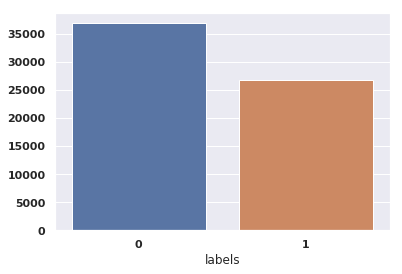

In [38]:
# number of labels of each type in training data
train_classes = train_df.groupby('labels').size()
sns.barplot(train_classes.index,train_classes.values)
plt.show()

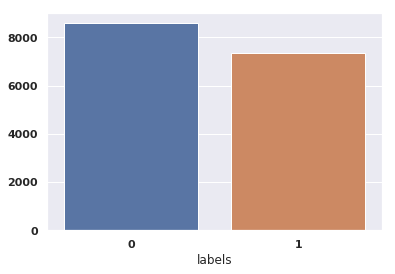

In [39]:
# number of labels of each type in test data
test_classes = test_df.groupby('labels').size()
sns.barplot(test_classes.index,test_classes.values)
plt.show()

## B

In [40]:
def accuracy_(preds,labels):
    return sum(labels==preds)/len(labels)

# We made these function with tp, fp and fn as parameters to stay general for both classes.
def precision_(tp, fp):
    return tp/(tp+fp)
def recall_(tp, fn):
    return tp/(tp+fn)
def f1_measure(precision, recall):
    return 2*((precision*recall)/(precision+recall))

In [41]:
# initialize the logistic regression classifer
clf = LogisticRegression(random_state=7).fit(train_df.iloc[:,:-1], train_df.iloc[:,-1])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We are using method clf.predict_proba which gives the probability of each class while clf.predict gives the labels by using a default threshold of 0.5 . We cross checked that using clf.predict_proba with threshold of 0.5 on test data gives the same accuracy as using clf.predict.

In [42]:
# get the probabilities of each class for each data point
class_prob = clf.predict_proba(test_df.iloc[:, :-1])
class_0_prob = class_prob[:,0]                #probabilty that animal is not adopted
class_1_prob = class_prob[:,1]                # probability that animal is adopted
test_pred = np.ones(class_0_prob.shape[0])    # intialize that all animal were  adopted
test_pred[class_0_prob >= 0.5] = 0  # if probability that animal was not adopted is greater than 0.5 then set it zero

In [43]:
# compute test accuracy with decision made with a threshold of 0.5
print('Test Accuracy :', np.sum(test_pred==test_df.iloc[:,-1])/test_df.shape[0])

Test Accuracy : 0.8523283544621564


Accuracy doesn't tell much. So to get more details we check the confusion matrix. In confusion matrix C[i,j] denotes the number of observation which should be in class i but predicted in class j.

In [44]:
# compute confusion matrix
confusion_matrix_lg = pd.crosstab(test_df['labels'],test_pred,rownames=['actual'],colnames=['predicted'])
confusion_matrix_lg

predicted,0.0,1.0
actual,,
0,7286,1297
1,1056,6295


In [45]:
# using scikit learn function to check
cf_skl = confusion_matrix(test_df['labels'],test_pred)
cf_skl

array([[7286, 1297],
       [1056, 6295]])

We calculate precision, recall and f1score. Precision tells how many selected items are relevant i.e. true positive divided by the total number of sample predicted in postive class (tp+fp).
Recall answers how many relevant items are selected i.e. true positive divided by the total number of actual positive samples (tp+fn).

In [46]:
# for Adapted (+ve) class
precision = precision_(cf_skl[1][1], cf_skl[0][1])
recall = recall_(cf_skl[1][1],cf_skl[1][0])
f1_score = f1_measure(precision,recall)
print('Precision : ',precision)
print('Recall : ',recall)
print('f1_score : ',f1_score)

Precision :  0.8291622760800843
Recall :  0.8563460753638961
f1_score :  0.842534966204912


In [47]:
# for negative class (non-adapted)
precision = precision_(cf_skl[0][0], cf_skl[1][0])
recall = recall_(cf_skl[0][0],cf_skl[0][1])
f1_score = f1_measure(precision,recall)
print('Precision : ',precision)
print('Recall : ',recall)
print('f1_score : ',f1_score)

Precision :  0.8734116518820427
Recall :  0.8488873354305022
f1_score :  0.8609748892171345


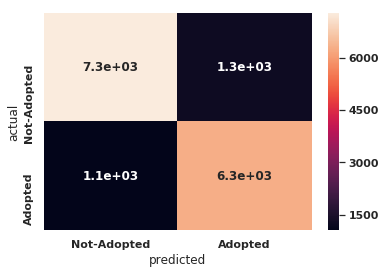

In [48]:
# plot confusion matrix 
label = ['Not-Adopted','Adopted']
sns.heatmap(confusion_matrix_lg,annot=True,xticklabels=label,yticklabels=label)
plt.show()

Generally it depends on task whether we want to extract all postive samples i.e. then false negative should be small, hence maximizing the recall serves best. But normally there is a trade-off then we also get some false positive misclassified as positive hence precision decreases.
Generally the metrics to be considered depend on the perspective of the user.
Here, the assumption is that the shelter puts to sleep all animals that aren't adopted due to limited space. So intuitevely, we would like to minimize the number of animals that are misclassified as not adopted while they should be adopted.This corresponds to maximizing the recall of the adopted class. But normally there is a trade-off that we also get some false positive misclassified as positive hence precision decreases and the shelter would ultimately be full
So to get the best out of this tradeoff we look at threshold vs precision-recall curve to choose the threshold which is suitable to the task. Looking at the f-measure is also insightful since it's a harmonic mean between the precision and recall.

We are assigning thresholds to be unique value of probabilities of postive class otherwise we could have used any log or normal distributions but that could have produced duplicate values for precision and recall.
For ex : if we choose threshold to be 0.1 and 0.15 and there are no values of predicted probability between them then obviously precision and recall will remain same i.e. wastage of computation power.

In [49]:
def precision_recall_computation(y_true, prob):
    ''' prob : probaility of postive class (in our case we assume Adopted class(labeled as 1) as positive)
        y_true : true labels '''
    
    thresholds = np.unique(prob) #assign threshold unique values of probabilites
    p = []
    r = []
    
    for t in thresholds:
        y_pred = np.zeros(prob.shape) # initialise as label 0
        y_pred[prob >= t] = 1     #if probability is greater than threshold then label as 1
        
        predicted_ps = (y_pred==1) #boolean array, True if predicted as positive
        tps = np.sum((y_pred == y_true) & predicted_ps)  # count all true positive
        total_ps = np.sum(predicted_ps)   # total number of samples predicted in positive class
        fps = total_ps - tps              # false positive
        
        fns = np.sum((y_pred != y_true) & (y_pred == 0)) # false negative i.e. checks if it false and also predicted negative

        
        precision = tps/(tps + fps)
        recall = tps/(tps + fns)
        p.append(precision)
        r.append(recall)
        
    p.append(1)
    r.append(0)
        
    return np.array(p), np.array(r), thresholds

In [50]:
# computes precision and recall values corresponding to a sequence of thresholds
p, r, thresholds = precision_recall_computation(np.array(test_df['labels']), class_1_prob)

In [51]:
# function to compute the accuracy for a sequence of thresholds
def compute_accuracy(thresholds, class_proba, test_label,class_):
    accuracy = []
    size = test_label.shape[0]
    for t in thresholds:
        if class_ == 1:
            test_pred = np.zeros(size)
        else:
            test_pred = np.ones(size)
        test_pred[class_proba > t] = class_
        acc = np.sum(test_pred==test_label)/size
        accuracy.append(acc)
    return np.array(accuracy)

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, class_proba, test_label,class_):
    accuracy = compute_accuracy(thresholds, class_proba, test_label,class_)
    f1_score = 2*((precisions*recalls)/(precisions+recalls))
    plt.figure(figsize=(10, 10))
    if class_==1:
        label = 'adopted'
    else:
        label = ' not adopted'
    plt.title("Precision and Recall Scores as a function of the decision threshold for "+label)
    plt.plot(thresholds, f1_score[:-1], "r-", label="f1_score")
    plt.plot(thresholds, accuracy, "k-", label="accuracy")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='plot_precision_recall_vs_threshold(p,r,thresholds, class_1_prob, test_df.iloc[:,-1],1)best')
    plt.show()

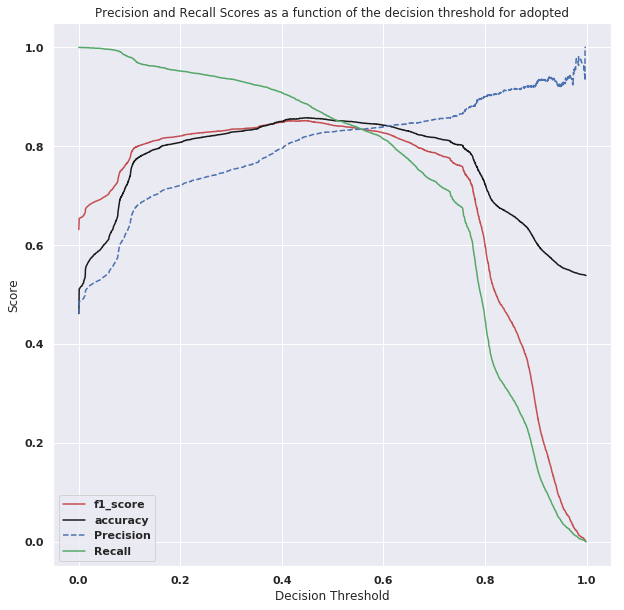

In [53]:
plot_precision_recall_vs_threshold(p,r,thresholds, class_1_prob, test_df.iloc[:,-1],1)

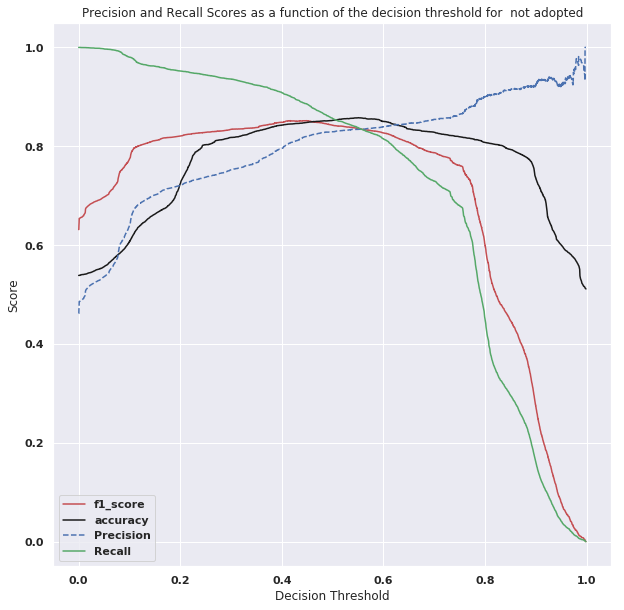

In [54]:
plot_precision_recall_vs_threshold(p,r,thresholds, class_0_prob, test_df.iloc[:,-1],0)

Fot threshold 0.4, the precision is 0.8 and the recall for adopted class is roughly 0.9 which means that 90% of the adopted animals are classified as so. The f-measure has ite peak around this threshold too. The acceptable thresholds and precision-recall values are a matter of discussion, choice and maybe regulations in the future.

# C

In [55]:
# 5 fold cross_validation returns the mean f-measure for the adopted class.

def cross_validation(clf, train_df, cv):  
    partition_size = train_df.shape[0]//cv
    idx = 0
    fscores = []
    accuracies = []
    for i in range(0,cv):
        validation_data = train_df[idx:idx+partition_size]
        train_data = train_df.drop(validation_data.index)
        clf.fit(train_data.drop(['labels'],axis=1), train_data['labels'])
        y_pred = clf.predict(validation_data.drop(['labels'],axis=1))
        accuracy = np.sum(y_pred==validation_data['labels'])/y_pred.shape[0]
        tp  = np.sum(np.logical_and(y_pred == 1, validation_data['labels'] ==1))
        fp  = np.sum(np.logical_and(y_pred == 1, validation_data['labels'] ==0))
        fn  = np.sum(np.logical_and(y_pred == 0, validation_data['labels'] ==1))
        if tp!=0:
            precision = precision_(tp,fp) 
            recall = recall_(tp,fn)
            fscore = f1_measure(precision,recall)  
        else:
            precision = 0
            recall = 0 
            fscore = 0
            accuracy = 0
        fscores.append(fscore)
        accuracies.append(accuracy)  
        idx = idx + partition_size
    return np.mean(fscores), np.mean(accuracies) 

In [56]:
clf = LogisticRegression(random_state=7)
clf.fit(train_df.iloc[:,:-1], train_df['labels'])
clf.coef_

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 0.10343238, -1.85402585,  0.79083997,  1.47820239, -0.43029979,
        -0.4682512 , -0.35028992, -0.08732523,  0.06370399,  0.06252922,
         2.24776707, -1.30326357, -1.32268283, -0.8317536 ,  0.58613999,
        -1.49031382, -0.26411645,  0.24620073, -0.03525661, -0.24788903,
         0.30186706, -0.30656481, -0.32223646,  1.58173853, -1.01183521,
         0.74130217, -2.19890197,  0.86673423,  0.77439099, -0.75005349,
        -0.58688368, -1.4415866 , -1.61566103, -1.82828104,  1.85261854,
         1.89551157, -1.4415866 ]])

Above you can find the classifier weights corresponding to each feature. Feature importance can be deduced from these weights: a small weight corresponds to a less important feature and vice versa. Performing feature selection this way supposes the interdependence of the features in an offline setting. <br>
Here we're going to perform backward greedy selection by ablation. The idea is to iteratively remove the features while crossvalidating the results (returning the mean of the k validation results) for combinations of features. Since going through all possible combinations is computationally heavy (O(n²)), we chose a number of combinations stochastically (20 combinations) and compare the fscore of each combination. <br> 
We didn't use the best features from the previous iteration with a lower number features beacause the features are n The choice of using the fscore as a metric comes from the fact that we're trying to reduce the percentage of misclassification of animals that should be adopted while maintaning the number of animals that are mistakenly adopted low to keep space in the shelter. <br> For each number of features considered, we acquire the best fscore and accuracy of the tested combinations. We also compare the best out of every combination between each other to get the features giving the best fscore out of all n_features and combinations tested. 

In [57]:
n_features =  [1, 5, 10, 15, 20, 25, 30]
best_fscore = 0
best_features = 0
# Taking all columns names
features_indicators = list(train_df)
features_indicators.remove('labels')
clf = LogisticRegression(random_state=7,n_jobs=-1)
# fscores and accuracies contain the best fscores and accuracies of each number of features in n_features
fscores = []
accuracies = []

for i in n_features:
    # fscores_combination and accuracies_combination contain all the fscores and accuracies of the current combination 
    fscores_combination  = []
    accuracies_combination = []
    # Choose 20 combinations of n_features[i] features
    for j in range(20):
        combination_sampled = list(np.random.choice(features_indicators,i,False))
        combination_sampled.append('labels')
        pruned_df = train_df[combination_sampled]
        # Perform cv and get the mean fscore and accuracy
        fscore, accuracy = cross_validation(clf,pruned_df,5)
        fscores_combination.append(fscore)
        accuracies_combination.append(accuracy)
        # check if this combination gives the best fscore so far
        if fscore > best_fscore:
            best_fscore = fscore
            best_features = combination_sampled
    accuracies.append(np.max(accuracies_combination))
    fscores.append(np.max(fscores_combination))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effe

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 

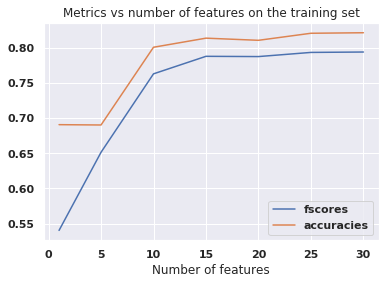

In [58]:
plt.figure()
plt.plot(n_features,fscores,label='fscores')
plt.plot(n_features,accuracies,label='accuracies')
plt.xlabel('Number of features')
plt.legend()
plt.title('Metrics vs number of features on the training set')
plt.show()

In [59]:
print('The best fscore on the training set is %f with %d features.'%(best_fscore,len(best_features)-1))
print('The best features (+Labels) in this scope are:')
print(best_features)

The best fscore on the training set is 0.794079 with 30 features.
The best features (+Labels) in this scope are:
['intake_condition_Pregnant', 'intake_year_2013', 'intake_year_2018', 'intake_condition_Nursing', 'intake_year_2014', 'sex_upon_outcome_Neutered Male', 'sex_upon_intake_Unknown', 'intake_type_Stray', 'animal_type_Other', 'time_in_shelter_days', 'intake_condition_Other', 'intake_condition_Normal', 'intake_number', 'sex_upon_outcome_Intact Male', 'intake_type_Euthanasia Request', 'sex_upon_outcome_Intact Female', 'intake_condition_Sick', 'age_upon_outcome_(years)', 'intake_year_2016', 'intake_year_2015', 'sex_upon_intake_Intact Male', 'sex_upon_intake_Intact Female', 'sex_upon_intake_Spayed Female', 'intake_type_Public Assist', 'intake_type_Wildlife', 'intake_condition_Aged', 'intake_year_2017', 'age_upon_intake_(years)', 'intake_condition_Feral', 'sex_upon_outcome_Unknown', 'labels']


In [60]:
# Train the classifier over the whole training set with the optimal set of features
clf = LogisticRegression(random_state=7)
opt_train = train_df[best_features]
clf.fit(opt_train.drop(['labels'],axis=1), opt_train['labels'])
# Test the classifier over the testing set with the optimal set of features
opt_test = test_df[best_features]
test_pred = clf.predict(opt_test.drop(['labels'],axis=1))

tp  = np.sum(np.logical_and(test_pred == 1, opt_test['labels'] ==1))
fn  = np.sum(np.logical_and(test_pred == 0, opt_test['labels'] ==1)) 
fp  = np.sum(np.logical_and(test_pred == 1, opt_test['labels'] ==0))

print('Test Accuracy : ', accuracy_(opt_test['labels'],test_pred))
print('Test Recall for adopted class : ', recall_(tp,fn))
print('Test Precision for adopted class : ', precision_(tp,fp))
print('Fscore for adopted class : ', f1_measure(precision_(tp,fp),
                                         recall_(tp,fn)))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test Accuracy :  0.8536462909501694
Test Recall for adopted class :  0.8552577880560468
Test Precision for adopted class :  0.8321641297154202
Fscore for adopted class :  0.8435529317053536


Previous results with all the features are the following: <br>
Test Accuracy : 0.8523283544621564 <br>
Recall :  0.8563460753638961 <br>
Precision :  0.8291622760800843 <br>
f1_score :  0.842534966204912 <br>

We can see that with the 30 features we obtained we get a slightly worse recall but better accuracy, precision and f1score. Different runs give very small fluctuated results sometimes with all metrics better than with the original complete sets of features. This is still a stochastic approach to feature selection and we're testing a small interval of number of features. Usually it takes more than one approach to get the optimal parameters although reducing the number of features while maintaning roughly the same performance is good in terms of reducing the computational cost of training and testing the model.


# D

In [61]:
# define the grid of hyper-prameters to be tuned
n_estimators = [int(x) for x in np.linspace(100,1000,num=15)]
max_depth = [int(x) for x  in np.linspace(3,18,num=15)]
param_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              }

In [62]:
best_score = 0
for n_estimator, max_depth in zip(n_estimators, max_depth):
    
    train_df = train_df.sample(frac=1, random_state=7).reset_index(drop=True)
    
    rfc=RandomForestClassifier(n_estimators = n_estimator,
                               max_depth=max_depth,
                               random_state=42,
                              n_jobs =-1)
    
    fscore, accuracy = cross_validation(rfc,train_df, cv = 5)
    if fscore > best_fscore :
        best_fscore = fscore
        best_estimator = n_estimator
        best_max_depth = max_depth  

In [63]:
# print the best parameters from the grid
print(' Optimal number of estimators : ', best_estimator )
print(' Optimal max depth : ', best_max_depth)
print(' Best fscore on the training set: ', best_fscore)

 Optimal number of estimators :  935
 Optimal max depth :  16
 Best fscore on the training set:  0.8388667294361547


In [64]:
best_clf = RandomForestClassifier(n_estimators=best_estimator,
                                 max_depth=best_max_depth,
                                 random_state=7,
                                 n_jobs=-1)

In [65]:
# predict over test data using the best parameter
best_clf.fit(train_df.drop(['labels'],axis=1), train_df['labels'])
test_pred = best_clf.predict(test_df.drop(['labels'],axis=1))
print('Test Accuracy : ', accuracy_(test_df['labels'],test_pred))

Test Accuracy :  0.8985188904229948


In [66]:
# compute confusion matrix
confusion_matrix_lg = pd.crosstab(test_df['labels'],test_pred,rownames=['actual'],colnames=['predicted'])
confusion_matrix_lg

predicted,0,1
actual,,
0,7452,1131
1,486,6865


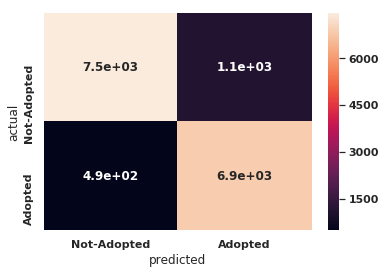

In [67]:
# plot confusion matrix
label = ['Not-Adopted','Adopted']
sns.heatmap(confusion_matrix_lg,annot=True,xticklabels=label,yticklabels=label)

In [68]:
# using sklearn to check
cf_skl = confusion_matrix(test_df['labels'],test_pred)
cf_skl

array([[7452, 1131],
       [ 486, 6865]])

In [69]:
# for Adapted (+ve) class
precision = precision_(cf_skl[1][1], cf_skl[0][1])
recall = recall_(cf_skl[1][1],cf_skl[1][0])
f1_score = f1_measure(precision,recall)
print('Precision : ',precision)
print('Recall : ',recall)
print('f1_score : ',f1_score)

Precision :  0.8585542771385692
Recall :  0.9338865460481567
f1_score :  0.8946373884146738


In [70]:
# for negative class (non-adapted)
precision = precision_(cf_skl[0][0], cf_skl[1][0])
recall = recall_(cf_skl[0][0],cf_skl[0][1])
f1_score = f1_measure(precision,recall)
print('Precision : ',precision)
print('Recall : ',recall)
print('f1_score : ',f1_score)

Precision :  0.9387755102040817
Recall :  0.8682278923453338
f1_score :  0.9021245687307063


We can obviously see that the random forest classifier performs better than the logistic regression classifier. Usually logistic regression is used when the data/feature are linearily separable. Random forest on the other hand is better suited to non-linear problems but is more prone to overfitting. Performing cross-validation (and boostrapping the features if wanted) overcomes this problem. Notice how throughout this assignement both classifiers performances is better on the testing set then on the validation sets. This can be explained by the fact that the training of the models for testing is performed over a bigger chunk of the data (including the validation set).